<div style="text-align: left; font-size: 28px;"><b>Session 7: Feature Engineering and Dealing with Imbalanced Data</b></div>
<br>
<div style="text-align: left; font-size: 18px;">Dr Adnane Ez-zizi</div>

In [ ]:
### Uncomment to install imblearn package if not already installed
# import sys
# !{sys.executable} -m pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import json
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
sns.set_style('whitegrid')

from sklearn.preprocessing import minmax_scale, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# I) Feature engineering for continuous data

[Adapted from Feature Engineering for Machine Learning, Chapter 2](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/).

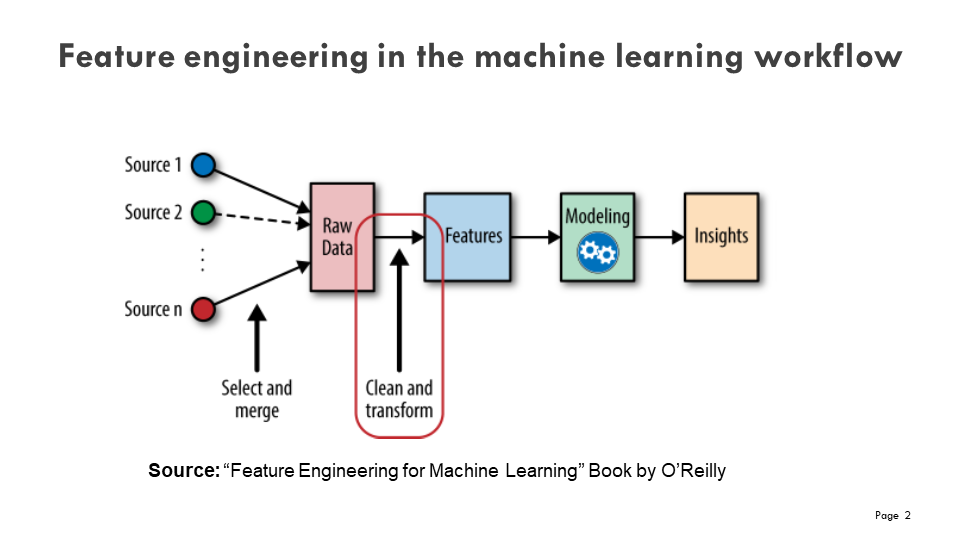

## 1) Log Transforms

We use logarithm transformation to get the distribution of a feature close to the normal distribution, especially when dealing with positive numbers with a heavytailed distribution (a heavy-tailed distribution places more probability mass in the
tail range than a Gaussian distribution) - this will become clearer in the examples below.

Here we will use only the natural logarithm function, which is the inverse of the exponential function, but know that you can use the logarithm function in general with any base. Let's make a graph of the natural logarithm to see how it looks like

<IPython.core.display.Javascript object>


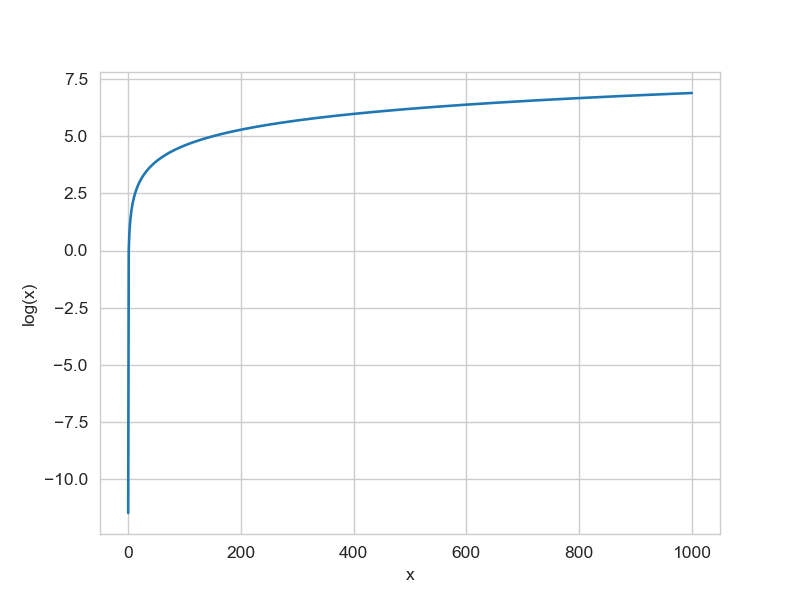

[Text(0.5, 0, 'x'), Text(0, 0.5, 'log(x)')]

In [11]:
### Plot of the natural logarithm function
x = np.linspace(0.00001, 1000, num = 1000)
y = np.log(x)

#sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
p = sns.lineplot(x=x, y=y)

# add label to the axis and label to the plot
p.set(xlabel ="x", ylabel = "log(x)")

### Log Transform on Boston Housing Dataset

In [12]:
# Loading the boston housing data
boston_df = pd.read_csv("Boston_house.csv")
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<IPython.core.display.Javascript object>


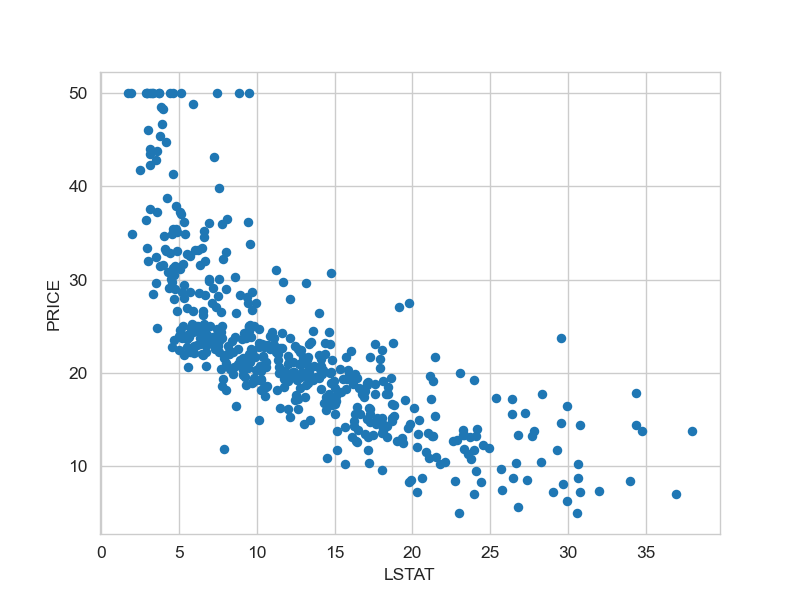

<AxesSubplot: xlabel='LSTAT', ylabel='PRICE'>

In [13]:
# Scatter plot to show the relationship between lstat and price
boston_df.plot.scatter(x="LSTAT", y='PRICE')

In [14]:
# Log-transformation
boston_df['log_LSTAT'] = boston_df['LSTAT'].apply(lambda x: np.log(x+1))
boston_df[['LSTAT', 'log_LSTAT']].head()

,LSTAT,log_LSTAT
0,4.98,1.788421
1,9.14,2.316488
2,4.03,1.615420
3,2.94,1.371181
4,5.33,1.845300


<IPython.core.display.Javascript object>


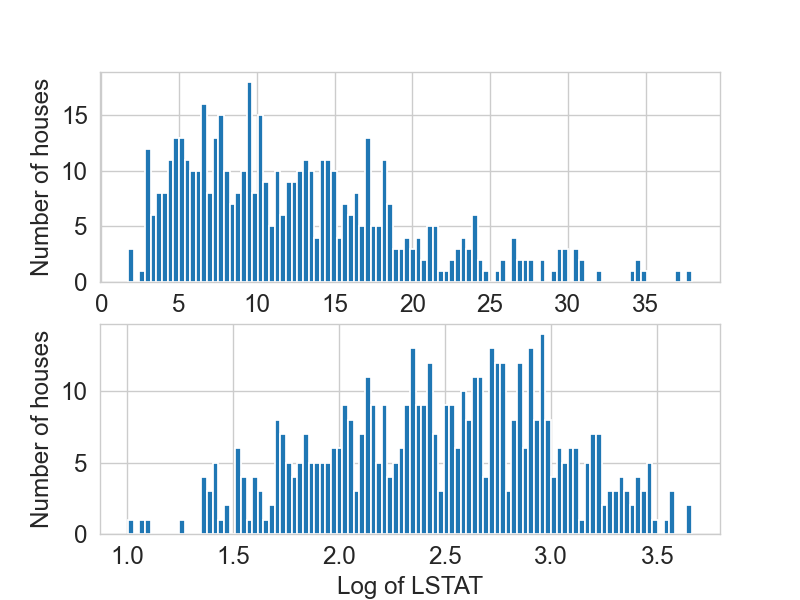

Text(0, 0.5, 'Number of houses')

In [15]:
## Visualize the distribution of review counts before and after log transform
plt.figure()
ax = plt.subplot(2,1,1)
boston_df['LSTAT'].hist(ax=ax, bins=100)
ax.tick_params(labelsize=14)
ax.set_xlabel('LSTAT', fontsize=14)
ax.set_ylabel('Number of houses', fontsize=14)

ax = plt.subplot(2,1,2)
boston_df['log_LSTAT'].hist(ax=ax, bins=100)
ax.tick_params(labelsize=14)
ax.set_xlabel('Log of LSTAT', fontsize=14)
ax.set_ylabel('Number of houses', fontsize=14)

In [17]:
## Train linear regression models to predict the average stars rating of a business,
## using the review_count feature with and without log transformation
## Compare the 10-fold cross validation score of the two models

# Simple linear regression using the original predictor LStat
m_orig = LinearRegression()
scores_orig = cross_val_score(m_orig, boston_df[['LSTAT']], boston_df['PRICE'], cv=10)
scores_orig

# Simple linear regression using the log-transformed predictor LStat
m_log = LinearRegression()
scores_log = cross_val_score(m_log, boston_df[['log_LSTAT']], boston_df['PRICE'], cv=10)

print("R-squared score without log transform: %0.5f (+/- %0.5f)" % (scores_orig.mean(), scores_orig.std() * 2))
print("R-squared score with log transform: %0.5f (+/- %0.5f)" % (scores_log.mean(), scores_log.std() * 2))

R-squared score without log transform: -0.18468 (+/- 1.46041)
R-squared score with log transform: 0.12432 (+/- 1.08448)


### Log Transform on Online News Popularity Dataset

In [11]:
# More details about the dataset can be found at: https://archive.ics.uci.edu/ml/datasets/online+news+popularity
df = pd.read_csv('OnlineNewsPopularity.csv', delimiter=', ', engine='python')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [12]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

### TODO Apply log-transform 

- Create a new column which is the log-transform of the number of tokens (i.e. "n_tokens_content") column.
- Plot the distribution of number of tokens with and without the log transform

In [14]:
df['log_n_tokens_content'] = np.log(df['n_tokens_content'] + 1)
df[['n_tokens_content', 'log_n_tokens_content']].head()

,n_tokens_content,log_n_tokens_content
0,219.0,5.393628
1,255.0,5.545177
2,211.0,5.356586
3,531.0,6.276643
4,1072.0,6.978214


### Plot the distribution of number of tokens with and without log transform

<IPython.core.display.Javascript object>


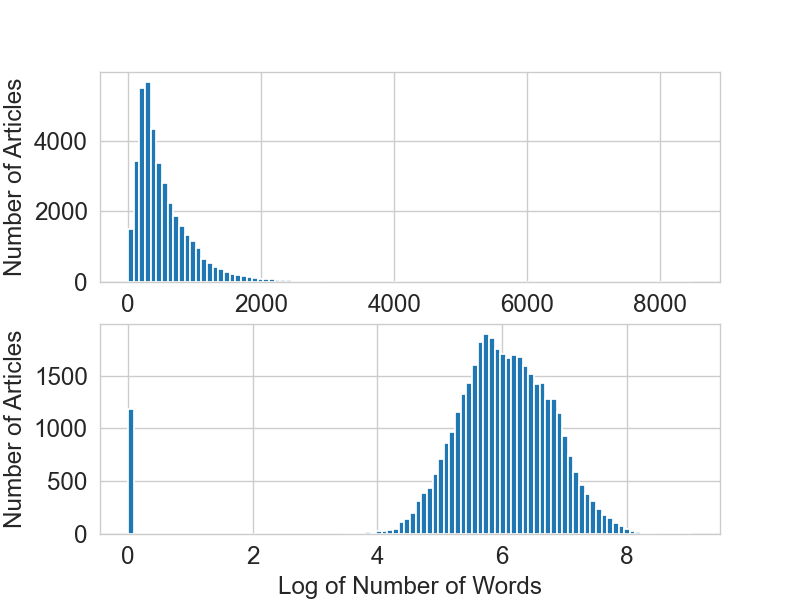

Text(0, 0.5, 'Number of Articles')

In [15]:
plt.figure()
ax = plt.subplot(2,1,1)
df['n_tokens_content'].hist(ax=ax, bins=100)
ax.tick_params(labelsize=14)
ax.set_xlabel('Number of Words in Article', fontsize=14)
ax.set_ylabel('Number of Articles', fontsize=14)

ax = plt.subplot(2,1,2)
df['log_n_tokens_content'].hist(ax=ax, bins=100)
ax.tick_params(labelsize=14)
ax.set_xlabel('Log of Number of Words', fontsize=14)
ax.set_ylabel('Number of Articles', fontsize=14)

### Visualize the correlation between the input and the output

<IPython.core.display.Javascript object>


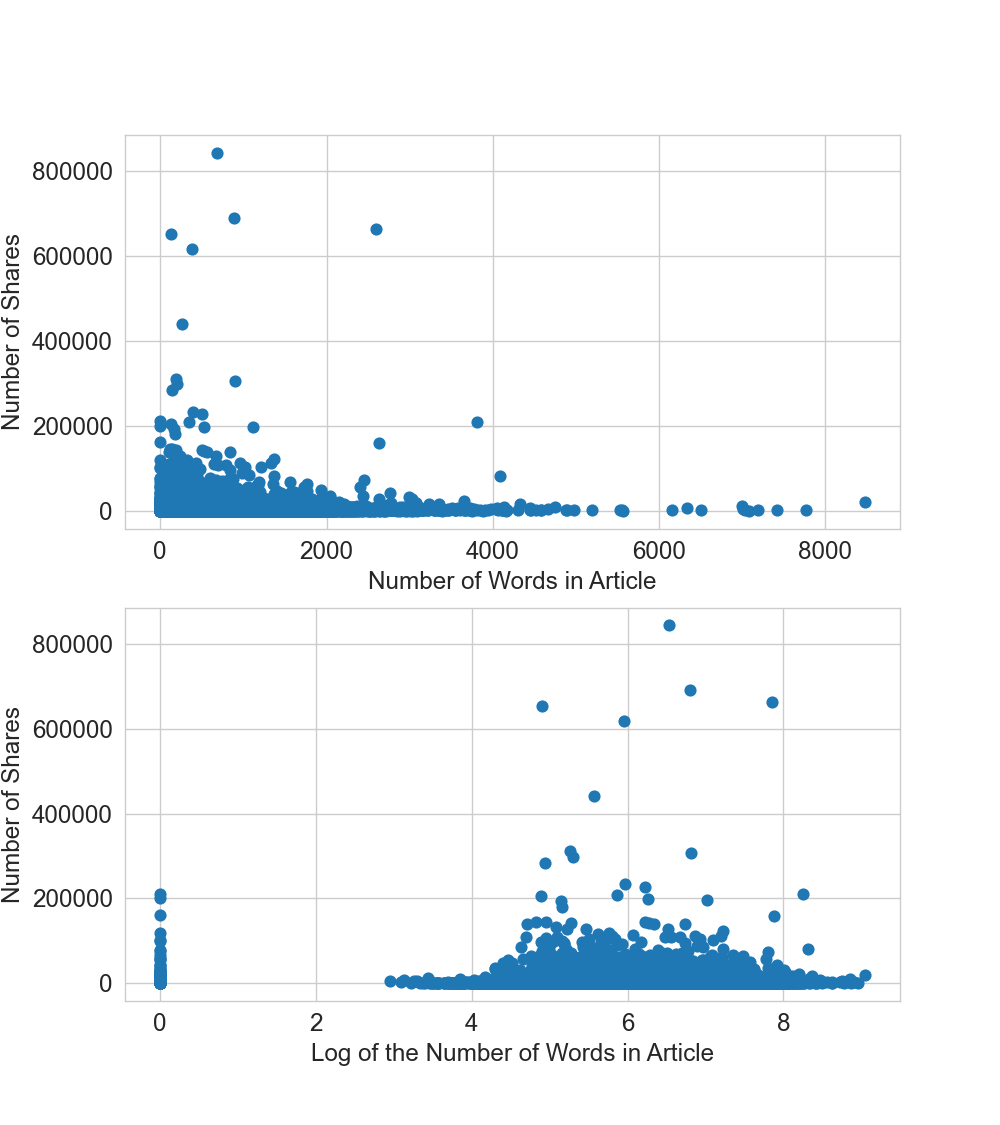

Text(0, 0.5, 'Number of Shares')

In [19]:
fig = plt.figure()
fig.set_size_inches(8, 9)
ax1 = plt.subplot(2,1,1)
ax1.scatter(df['n_tokens_content'], df['shares'])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Number of Words in Article', fontsize=14)
ax1.set_ylabel('Number of Shares', fontsize=14)

ax2 = plt.subplot(2,1,2)
ax2.scatter(df['log_n_tokens_content'], df['shares'])
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Log of the Number of Words in Article', fontsize=14)
ax2.set_ylabel('Number of Shares', fontsize=14)

### TODO Compare linear regression with and without the transform

- Calculate the R-score of simple linear regression that predicts "shares" using "n_tokens_content". Use 10-fold cross validation as we did above.
- Compare it to the R-score of simple linear regression that predicts "shares" using the log-transform of "n_tokens_content"

In [21]:
news_orig_model = LinearRegression()
scores_orig = cross_val_score(news_orig_model, df[['n_tokens_content']], df['shares'], cv=10)

news_log_model = LinearRegression()
scores_log = cross_val_score(news_log_model, df[['log_n_tokens_content']], df['shares'], cv=10)

print("R-squared score without log transform: %0.5f (+/- %0.5f)" % (scores_orig.mean(), scores_orig.std() * 2))

print("R-squared score with log transform: %0.5f (+/- %0.5f)" % (scores_log.mean(), scores_log.std() * 2))

R-squared score without log transform: -0.00242 (+/- 0.00509)
R-squared score with log transform: -0.00114 (+/- 0.00418)


## 2) Power Transforms: Generalization of the Log Transform

The log transform is a specific example of a family of transformations known as power transforms. In statistical terms, these are *variance-stabilizing transformations*. The family of power transforms is also known as the Box-Cox transform:

\begin{equation}
x = 
\begin{cases}
    \frac{x^\lambda-1}{\lambda} & \text{if } \lambda~\neq0, \\
    \ln(x) & \text{if } \lambda~=0
\end{cases}
\end{equation}

The equations imply that setting $\lambda$ to be less than 1 compresses the higher values, and setting $\lambda$ higher than 1 has the opposite effect.

### Power transformation of Boston housing data

In [22]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,log_LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,1.788421
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,2.316488
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,1.615420
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,1.371181
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,1.845300


We will apply Box-Cox transformation to the "LSTAT" column. The Box-Cox formulation only works when the data is positive (for nonpositive data, one could shift the values by adding a fixed constant). We thus need to check that the minimum value of LSTAT is greater than 0.

In [23]:
# Box-Cox transform assumes that input data is positive. 
# Check the min to make sure.
boston_df['LSTAT'].min()

1.73

When applying the Box-Cox transformation or a more general power transform, we have to determine a value for the parameter $\lambda$.

In [18]:
# Setting input parameter lmbda to 0 gives us the log transform (without constant offset)
rc_log = stats.boxcox(boston_df['LSTAT'], lmbda=0)

# By default, the scipy implementation of Box-Cox transform finds the lambda parameter that will make the output 
# the closest to a normal distribution
rc_bc, bc_params = stats.boxcox(boston_df['LSTAT'])
bc_params

0.22776736893884023

So the estimated value of $\lambda$ is 0.23

In [27]:
boston_df['rc_bc'] = rc_bc
boston_df['rc_log'] = rc_log

Let's now visualise the histograms of original, log transformed, and Box-Cox transformed LSTAT variable.

<IPython.core.display.Javascript object>


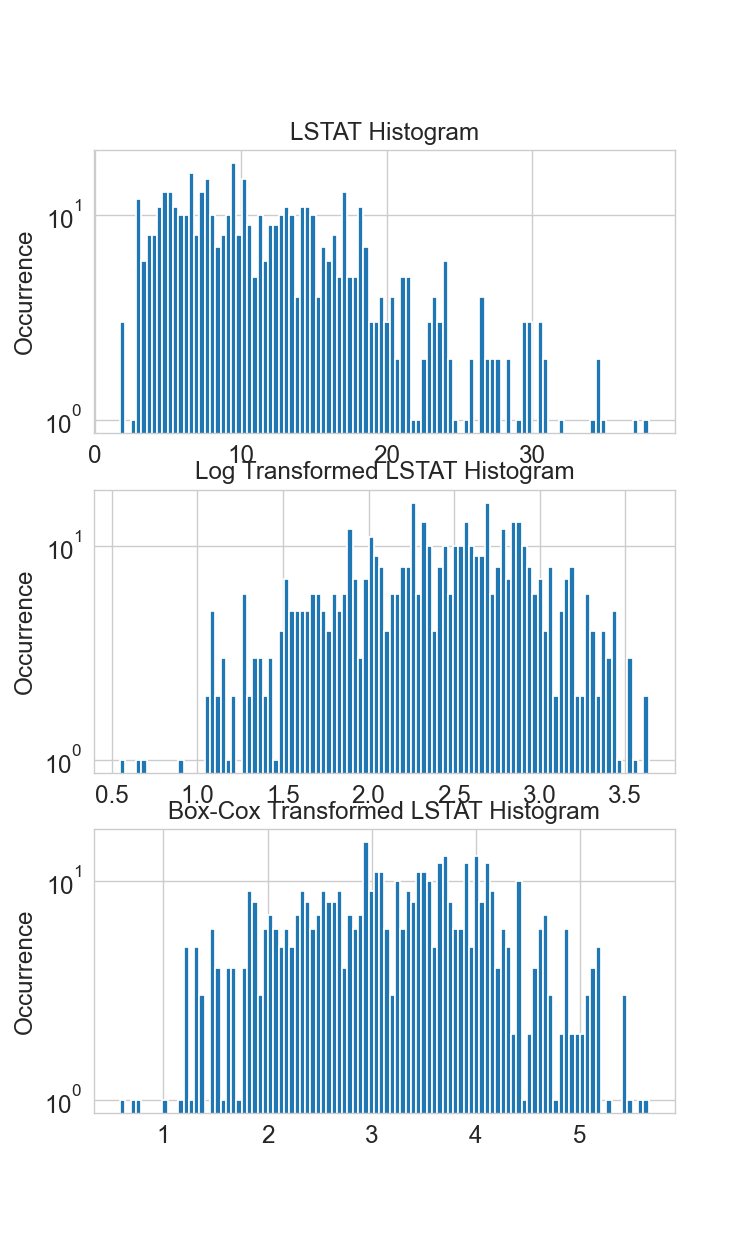

Text(0, 0.5, 'Occurrence')

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_size_inches(6, 10)

# original review count histogram
boston_df['LSTAT'].hist(ax=ax1, bins=100)
ax1.set_yscale('log')
ax1.tick_params(labelsize=14)
ax1.set_title('LSTAT Histogram', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrence', fontsize=14)

# review count after log transform
boston_df['rc_log'].hist(ax=ax2, bins=100)
ax2.set_yscale('log')
ax2.tick_params(labelsize=14)
ax2.set_title('Log Transformed LSTAT Histogram', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Occurrence', fontsize=14)

# review count after optimal Box-Cox transform
boston_df['rc_bc'].hist(ax=ax3, bins=100)
ax3.set_yscale('log')
ax3.tick_params(labelsize=14)
ax3.set_title('Box-Cox Transformed LSTAT Histogram', fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel('Occurrence', fontsize=14)

A probability plot, or probplot, is an easy way to visually compare an empirical distribution of data against a theoretical distribution. This is essentially a scatter plot of observed versus theoretical quantiles. The plot below shows the probplots of original and transformed LSTAT data against the normal distribution. 

<IPython.core.display.Javascript object>


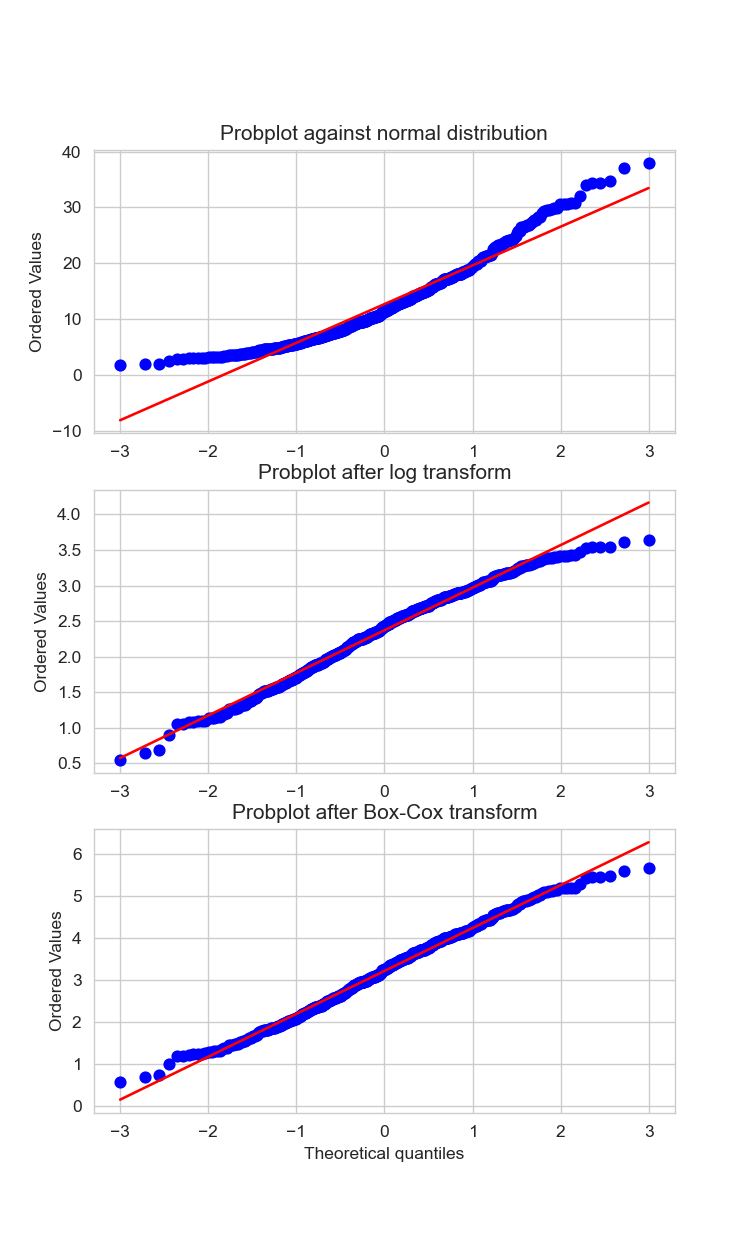

Text(0.5, 1.0, 'Probplot after Box-Cox transform')

In [29]:
fig2, (ax1, ax2, ax3) = plt.subplots(3,1)
fig2.set_size_inches(6, 10)

prob1 = stats.probplot(boston_df['LSTAT'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

prob2 = stats.probplot(boston_df['rc_log'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('')
ax2.set_title('Probplot after log transform')

prob3 = stats.probplot(boston_df['rc_bc'], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_title('Probplot after Box-Cox transform')

Since the observed data is strictly positive and the Gaussian can be negative, the quantiles could never match up on the negative end. Thus, our focus is on the positive side. On this front, the original values are more heavy-tailed than a normal distribution - The ordered values go up to 40, whereas the theoretical quantiles only stretch to 3. Both the plain log transform and the optimal Box-Cox transform bring the positive tail closer to normal, but the optimal Box-Cox transform does a better job.

### Power transformation of Yelp business review counts

For this exercise, we take data from round 6 of the Yelp dataset challenge and create a much smaller classification dataset. The Yelp dataset contains user reviews of businesses from 10 cities across North America and Europe. Each business is labeled with
zero or more categories.

Each business has a review count. Suppose our task is to predict the rating a user might give to a business. The review count might be a useful input feature because there is usually a strong correlation between popularity and good ratings. Now the question is, should we use the raw review count or process it further?

In [19]:
# Load the dataset as a pandas dataframe
biz_f = open('yelp_academic_dataset_business.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])
biz_f.close()
biz_df.head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,O_X3PGhk3Y5JWVi866qlJg,"1501 W Bell Rd\nPhoenix, AZ 85023","{'Monday': {'close': '18:00', 'open': '11:00'}...",True,"[Active Life, Arts & Entertainment, Stadiums &...",Phoenix,29,Turf Paradise Race Course,[],-112.092329,AZ,4.0,33.638573,"{'Take-out': False, 'Wi-Fi': 'free', 'Good For...",business
1,QbrM7wqtmoNncqjc6GtFaQ,"18501 N 83rd Avenue\nGlendale, AZ 85308",{},True,"[Tires, Automotive, Fashion, Shopping, Departm...",Glendale,3,Sam's Club Members Only,[],-112.234755,AZ,3.5,33.648545,"{'Parking': {'garage': False, 'street': False,...",business
2,7lbvsGKzhjuX3oJtaXJvOg,"5000 S Arizona Mills Cir\nSte 590\nTempe, AZ 8...","{'Monday': {'close': '21:00', 'open': '10:00'}...",True,"[Women's Clothing, Men's Clothing, Fashion, Sh...",Tempe,7,Forever 21,[],-111.964485,AZ,3.5,33.383123,"{'Parking': {'garage': False, 'street': False,...",business
3,gjxoKVsRJwEoa8zd9XxlAw,"912 W Sycamore Pl\nChandler, AZ 85225","{'Monday': {'close': '19:00', 'open': '06:00'}...",True,"[Pet Services, Pet Boarding/Pet Sitting, Pets]",Chandler,4,Loving Hands Pet Care,[],-111.857818,AZ,5.0,33.356472,{},business
4,V28yjMqyZnbCtabroJN_aA,"1745 W Glendale Ave\nPhoenix, AZ 85021",{},True,"[Veterinarians, Pets]",Phoenix,3,Amec Mid-City Animal Hospital,[],-112.097232,AZ,5.0,33.538493,{},business


### TODO Compute Cox-Box transform

- Compute the log-transform of "review_count"
- Compute the best power-transform of "review_count" using Cox-Box method.
- Use the historgram and probability plots to assess the success of your Cox-Box transformation. 

In [31]:
# Box-Cox transform assumes that input data is positive. 
# Check the min to make sure.
biz_df['review_count'].min()

3

In [32]:
# Setting input parameter lmbda to 0 gives us the log transform (without constant offset)
rc_log = stats.boxcox(biz_df['review_count'], lmbda=0)
# By default, the scipy implementation of Box-Cox transform finds the lmbda parameter
# that will make the output the closest to a normal distribution
rc_bc, bc_params = stats.boxcox(biz_df['review_count'])
bc_params

-0.5408563789457254

In [33]:
biz_df['rc_bc'] = rc_bc
biz_df['rc_log'] = rc_log

<IPython.core.display.Javascript object>


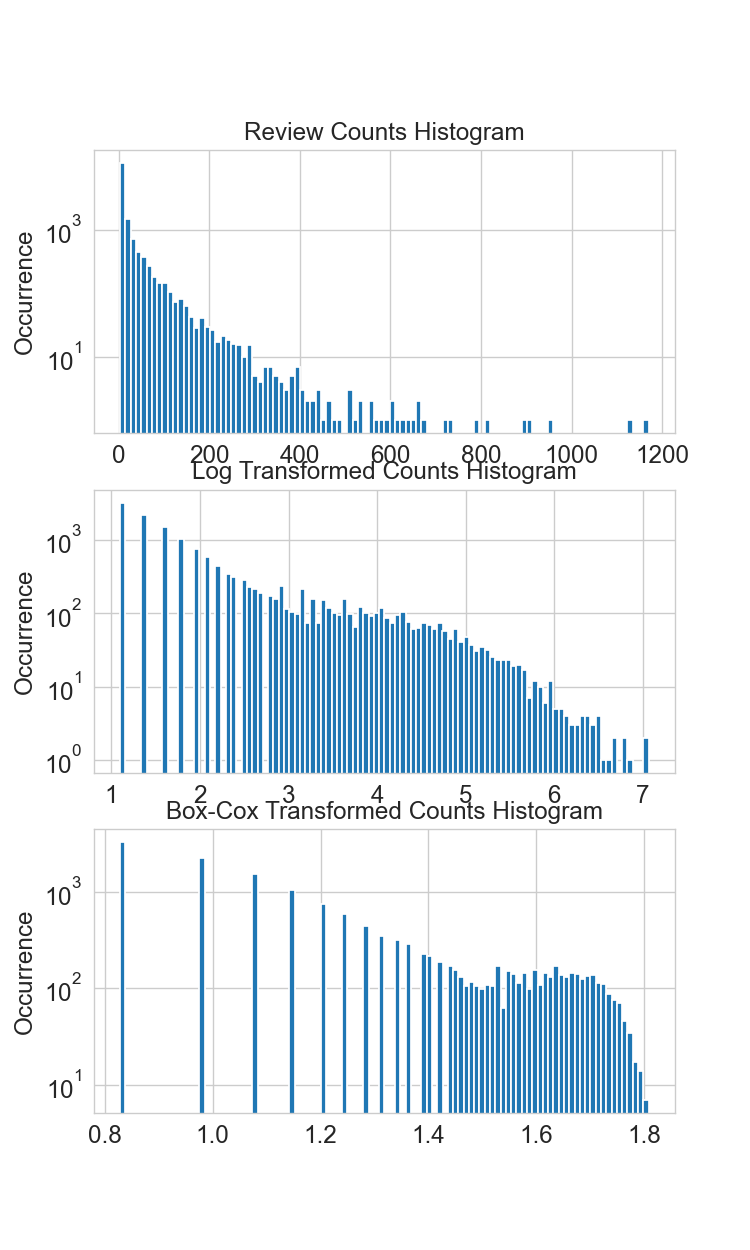

Text(0, 0.5, 'Occurrence')

In [34]:
# Visualizing the distribution of review counts before and after the log and Cox-Box transforms
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_size_inches(6, 10)

# original review count histogram
biz_df['review_count'].hist(ax=ax1, bins=100)
ax1.set_yscale('log')
ax1.tick_params(labelsize=14)
ax1.set_title('Review Counts Histogram', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrence', fontsize=14)

# review count after log transform
biz_df['rc_log'].hist(ax=ax2, bins=100)
ax2.set_yscale('log')
ax2.tick_params(labelsize=14)
ax2.set_title('Log Transformed Counts Histogram', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Occurrence', fontsize=14)

# review count after optimal Box-Cox transform
biz_df['rc_bc'].hist(ax=ax3, bins=100)
ax3.set_yscale('log')
ax3.tick_params(labelsize=14)
ax3.set_title('Box-Cox Transformed Counts Histogram', fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel('Occurrence', fontsize=14)

In [52]:
#fig.savefig('box-cox-hist.jpg')

Let's now visualise the probability plots before and after the feature transformations

<IPython.core.display.Javascript object>


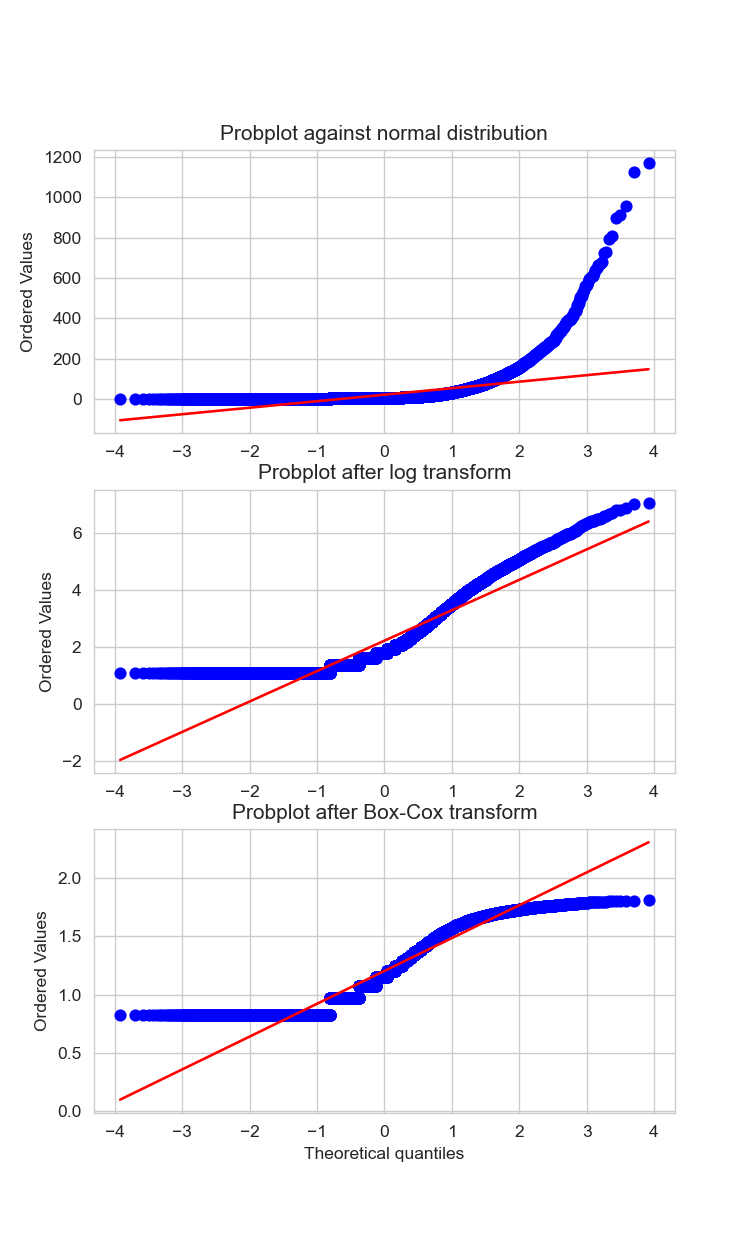

Text(0.5, 1.0, 'Probplot after Box-Cox transform')

In [35]:
fig2, (ax1, ax2, ax3) = plt.subplots(3,1)
fig2.set_size_inches(6, 10)

prob1 = stats.probplot(biz_df['review_count'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

prob2 = stats.probplot(biz_df['rc_log'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('')
ax2.set_title('Probplot after log transform')

prob3 = stats.probplot(biz_df['rc_bc'], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_title('Probplot after Box-Cox transform')

## 3) Feature Scaling or Normalization

Some features, such as latitude or longitude, are bounded in value. Other numeric features, such as counts, may increase without bound. Models that are smooth functions of the input, such as linear regression, logistic regression, or anything that involves a matrix, are affected by the scale of the input (tree-based models, which we will cover in the next session, are not affected by this).

If your model is sensitive to the scale of input features, feature scaling could help. As the name suggests, feature scaling changes the scale of the feature. Sometimes people also call it feature normalization. Feature scaling is usually done individually to each feature. Next, we will discuss several types of common scaling operations, each resulting in a different distribution of feature values.

### Min-Max Scaling

Let x be an individual feature value (i.e., a value of the feature in some data point), and min(x) and max(x), respectively, be the minimum and maximum values of this feature over the entire dataset. Min-max scaling squeezes (or stretches) all feature
values to be within the range of [0, 1]. The formula for min-max scaling is:

\begin{equation}
\tilde{x} = \frac{x-min(x)}{max(x)-min(x)}
\end{equation}

Let's apply Min-Max scaling to the "number of tokens" feature in the Online News Popularity dataset

In [23]:
# Load the dataset
df = pd.read_csv('OnlineNewsPopularity.csv', delimiter=', ', engine='python')
# Check the 'n_tokens_content' variable
df['n_tokens_content'].head(10)

0     219.0
1     255.0
2     211.0
3     531.0
4    1072.0
5     370.0
6     960.0
7     989.0
8      97.0
9     231.0
Name: n_tokens_content, dtype: float64

In [26]:
# Now let's apply min-max
df['minmax'] = minmax_scale(df[['n_tokens_content']])
df['minmax'].head(10)

0    0.025844
1    0.030092
2    0.024900
3    0.062662
4    0.126505
5    0.043663
6    0.113288
7    0.116710
8    0.011447
9    0.027260
Name: minmax, dtype: float64

### Standardization (Variance Scaling)

Feature standardization is defined as:

\begin{equation}
\tilde{x} = \frac{x-mean(x)}{sqrt(var(x))}
\end{equation}

It subtracts off the mean of the feature (over all data points) and divides by the variance. Hence, it can also be called variance scaling. The resulting scaled feature has a mean of 0 and a variance of 1. If the original feature has a Gaussian distribution, then the scaled feature does too. Let's apply Standardization to the "number of tokens" feature in the Online News Popularity dataset

In [28]:
df['standardized'] = StandardScaler().fit_transform(df[['n_tokens_content']])
df[['n_tokens_content', 'minmax', 'standardized']].head(10)

,n_tokens_content,minmax,standardized
0,219.0,0.025844,-0.695210
1,255.0,0.030092,-0.618794
2,211.0,0.024900,-0.712192
3,531.0,0.062662,-0.032933
4,1072.0,0.126505,1.115439
5,370.0,0.043663,-0.374685
6,960.0,0.113288,0.877699
7,989.0,0.116710,0.939257
8,97.0,0.011447,-0.954178
9,231.0,0.027260,-0.669738


<IPython.core.display.Javascript object>


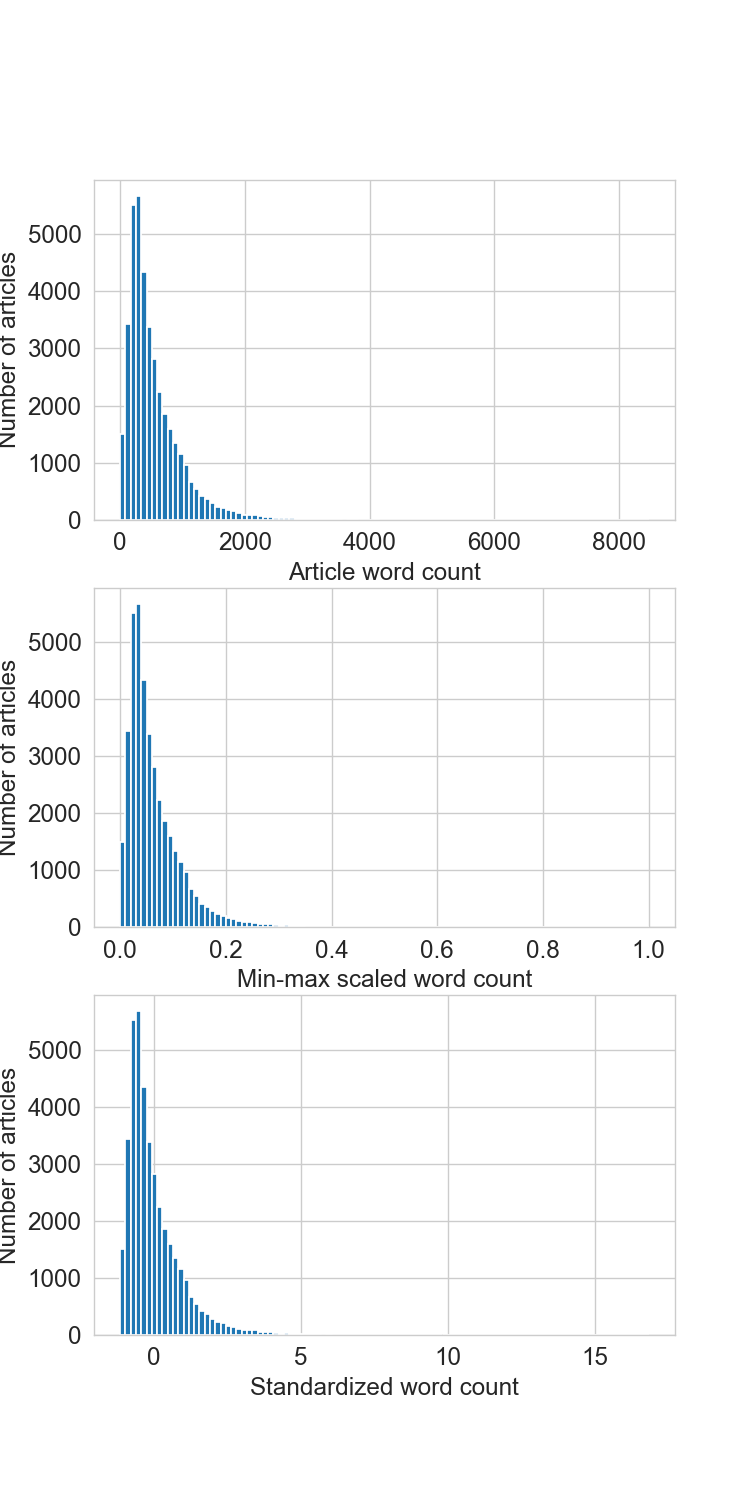

Text(0, 0.5, 'Number of articles')

In [32]:
# Plotting the histograms of original and scaled data
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_size_inches(6, 12)

df['n_tokens_content'].hist(ax=ax1, bins=100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Article word count', fontsize=14)
ax1.set_ylabel('Number of articles', fontsize=14)

df['minmax'].hist(ax=ax2, bins=100)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Min-max scaled word count', fontsize=14)
ax2.set_ylabel('Number of articles', fontsize=14)

df['standardized'].hist(ax=ax3, bins=100)
ax3.tick_params(labelsize=14)
ax3.set_xlabel('Standardized word count', fontsize=14)
ax3.set_ylabel('Number of articles', fontsize=14)

# II) Feature engineering for categorical data

[Adapted from Feature Engineering for Machine Learning, Chapter 5](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/).

The categories of a categorical variable are usually not numeric. For example, eye color can be "black", "blue", "brown". Thus, an encoding method is needed to turn these nonnumeric categories into numbers. It is tempting to simply assign an integer, say from 1 to k, to each of k possible categories—but the resulting values would be orderable against each other, which should not be permissible for categories. So, let's look at some alternatives.

## 1) One-hot encoding

We first create a dataframe with one column, "City", which is categorical and another column, "Rent". The dataset is assumed to contain rental prices in 3 cities: New York, San Francisco and Seatle.

In [37]:
df = pd.DataFrame({'City': ['SF', 'SF', 'SF', 'NYC', 'NYC', 'NYC', 'Seattle', 'Seattle', 'Seattle'],
                   'Rent': [3999, 4000, 4001, 3499, 3500, 3501, 2499, 2500, 2501]})
df

,City,Rent
0,SF,3999
1,SF,4000
2,SF,4001
3,NYC,3499
4,NYC,3500
5,NYC,3501
6,Seattle,2499
7,Seattle,2500
8,Seattle,2501


One-hot encoding method converts a categorical variable of k categories into k binary features (or columns), each of which represents one category. Each feature can be "on" (value of one) or "off" (value of zero) depending on whether the category appears for that observation. The code below provides a concrete example for how the dataframe we just created can be converted using one-hot encoding.

In [38]:
# Convert the categorical variables in the DataFrame to one-hot encoding
one_hot_df = pd.get_dummies(df, prefix = ['city'])
one_hot_df

,Rent,city_NYC,city_SF,city_Seattle
0,3999,0,1,0
1,4000,0,1,0
2,4001,0,1,0
3,3499,1,0,0
4,3500,1,0,0
5,3501,1,0,0
6,2499,0,0,1
7,2500,0,0,1
8,2501,0,0,1


In [41]:
# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(one_hot_df[['city_NYC', 'city_SF', 'city_Seattle']], one_hot_df['Rent'])
print(f'The slope coefficents of the linear regression model: {lin_reg.coef_}')
print(f'The intercept of the linear regression model: {lin_reg.intercept_}')

The slope coefficents of the linear regression model: [ 166.66666667  666.66666667 -833.33333333]
The intercept of the linear regression model: 3333.3333333333335


With one-hot encoding, the intercept represents the mean value of the response (i.e. dependent) variable, Rent. Each of the linear coefficients represents how much that city's average rent differs from the global mean.

In [27]:
# The intercept represents the mean value of the dependent variable 
df['Rent'].mean()

3333.3333333333335

## 2) Dummy coding

One-hot encoding creates one binary feature for each category. This create redundancy because the last bit is not really needed: if we know the other bits, we can infer the last one because only one category is taken. For example, if we know that [1, 0, 0] represents "New York" and [0, 1, 0] represents "San Francesco" we don't need another binary variable to represent "Seattle". We could simply use 0 for both "New York" and "San Francesco", i.e., [0, 0]. This is called a dummy variable encoding where we represent k categories with k-1 binary features.

In [42]:
dummy_df = pd.get_dummies(df, prefix = ['city'], drop_first = True)
dummy_df

,Rent,city_SF,city_Seattle
0,3999,1,0
1,4000,1,0
2,4001,1,0
3,3499,0,0
4,3500,0,0
5,3501,0,0
6,2499,0,1
7,2500,0,1
8,2501,0,1


In [43]:
# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(dummy_df[['city_SF', 'city_Seattle']], dummy_df['Rent'])
print(f'The slope coefficents of the linear regression model: {lin_reg.coef_}')
print(f'The intercept of the linear regression model: {lin_reg.intercept_}')

The slope coefficents of the linear regression model: [  500. -1000.]
The intercept of the linear regression model: 3500.0000000000005


With dummy coding, the intercept represents the mean value of the response variable y for the reference category, which in the example is the city NYC. The coefficient for the ith feature is equal to the difference between the mean response value for the ith category and the mean of the reference category.

Note how the dummy coding and one-hot encoding produce different coefficients and intercepts.

## 3) Comparison between one-hot encoding and dummy coding 

One-hot and dummy coding are very similar to one another. They each have pros and cons. One-hot encoding is redundant, which allows for multiple valid models for the same problem. The nonuniqueness is sometimes problematic for interpretation, but the advantage is that each feature clearly corresponds to a category. Moreover, missing data can be encoded as the all-zeros vector, and the output should be the overall mean of the target variable.

Dummy coding is not redundant, which gives rise to unique and interpretable models. The downside of dummy coding is that it cannot easily handle missing data, since the all-zeros vector is already mapped to the reference category. It also encodes the effect of each category relative to the reference category, which may not be the natural way you will want to interpret your models.

# III) Fitting model on imbalanced datasets and how to fight bias

In [ ]:
# Slide 1

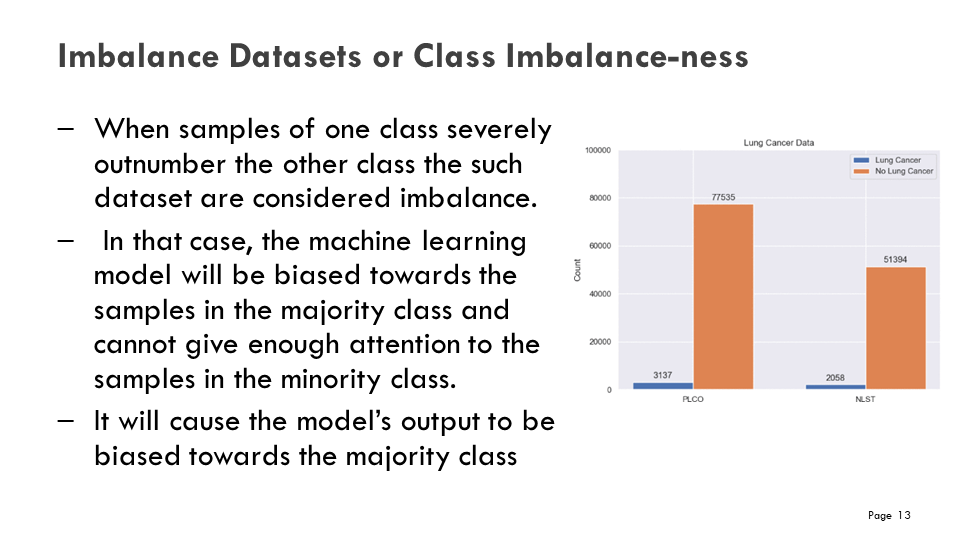

In [ ]:
# Slide 2

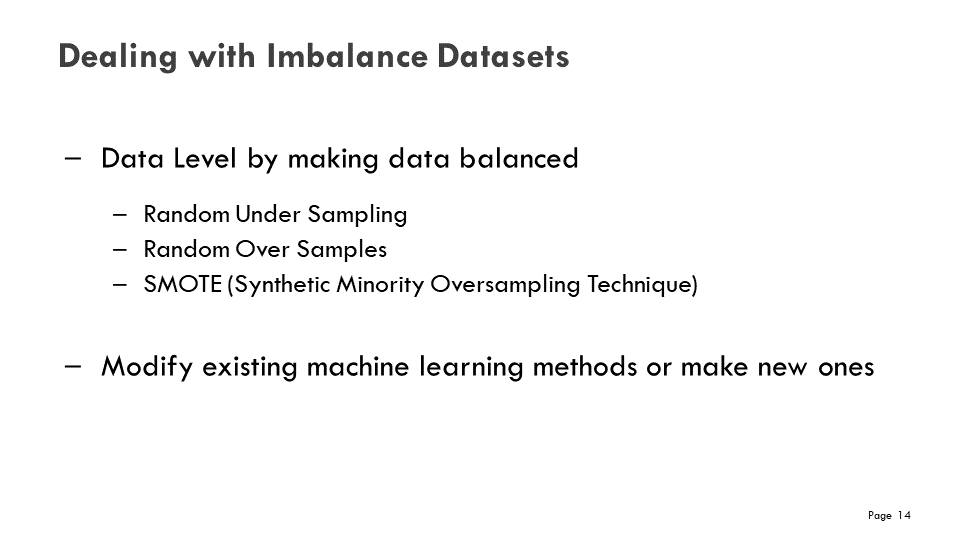

In [ ]:
# Slide 3

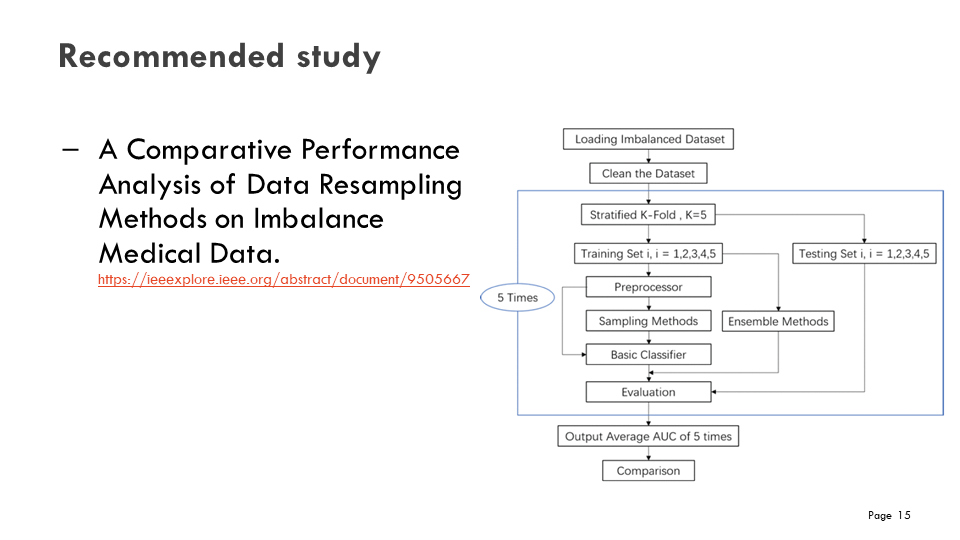

In [ ]:
# Slide 4

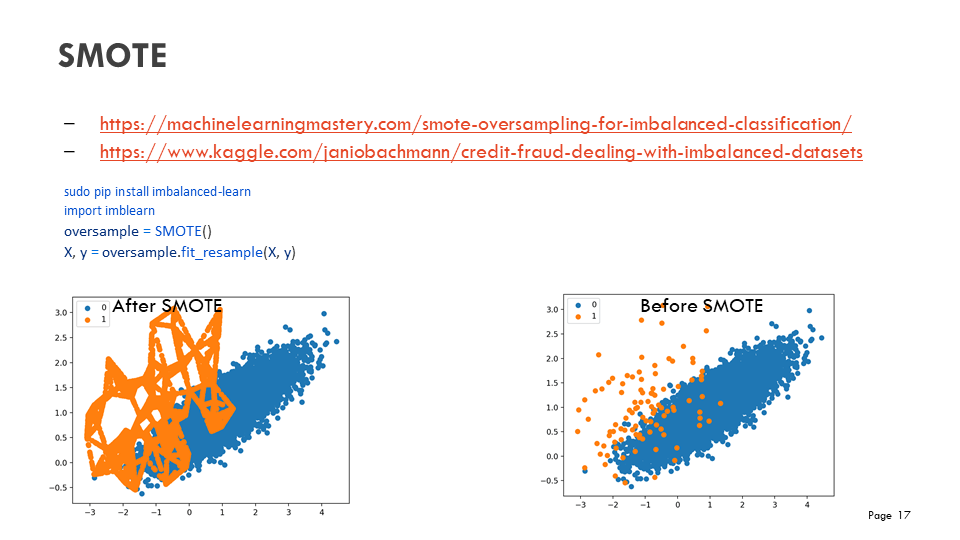


## Example

This example illustrates the problem induced by learning on datasets having imbalanced classes. Subsequently, we compare different approaches alleviating these negative effects.

In [ ]:
# Orignal Author: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT
# Original source: https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html#sphx-glr-auto-examples-applications-plot-impact-imbalanced-classes-py
# Modified by Dr Adnane Ez-zizi 

### Dataset

We are using a modified version of the "adult" (income) dataset from sklearn.datasets without dropping features:

- "fnlwgt": this feature was created while studying the "adult" dataset. Thus, we will not use this feature which is not acquired during the survey.
- "education-num": it is encoding the same information than "education". Thus, we are removing one of these 2 features.

In [2]:
df = pd.read_csv("Adult_income.csv")
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
3,34.0,Private,10th,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
4,29.0,NaN,HS-grad,Never-married,NaN,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K


Let's separate the predictors and response variable.

In [3]:
X = df.drop(columns = 'class')
Y = df['class']

The dataset has a class ratio of 30:1 in favour of the class <=50K, so very imbalanced.

In [4]:
classes_count = Y.value_counts()
classes_count

<=50K    37155
>50K      1238
Name: class, dtype: int64

### Strategies to learn from an imbalanced dataset
We will use a dictionary and a list to continuously store the results of our experiments and show them as a pandas dataframe.

In [21]:
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}

We will perform a cross-validation evaluation to get an estimate of the test accuracy score. We will using both the standard accuracy and the balanced accuracy, which is the average the accuracy over both classes.

As a baseline, we could use a classifier which will always predict the majority class independently of the features provided. This is what we call the dummy baseline.

In [22]:
# Split the data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, stratify = Y)

### Dummy baseline

Before to train a real machine learning model, we can store the results
obtained with our :class:`~sklearn.dummy.DummyClassifier`.

In [23]:
index.append("Dummy classifier")
scoring = ["accuracy", "balanced_accuracy"]
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.5


### Linear classifier baseline

We will create a machine learning pipeline using a `sklearn.linear_model.LogisticRegression` classifier and 5-fold cross-validation. As part of this pipline, we will need to one-hot encode the categorical columns and standardized the numerical columns before to inject the data into the `sklearn.linear_model.LogisticRegression` classifier.

First, we define our numerical and categorical pipelines.

In [24]:
########### Run Logistic regression ############

# Identifying continuous and categorical columns
continuous_columns = X.select_dtypes(include="number").columns
categorical_columns = X.select_dtypes(exclude="number").columns

### Preprocessing continuous columns for this fold
# Step 1: Impute missing values for continuous columns with their mean
imputer_cont = SimpleImputer(strategy='mean')
X_train_cont_imputed = imputer_cont.fit_transform(X_train[continuous_columns])
# Step 2: Scale the continuous columns
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train_cont_imputed)
# Step 3: Apply the same transformation to test data
X_test_cont_imputed = imputer_cont.transform(X_test[continuous_columns])
X_test_cont_scaled = scaler.transform(X_test_cont_imputed)

### Preprocessing categorical columns for this fold
# Step 1: Impute missing values for categorical columns with the value 'missing'
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat_imputed = imputer_cat.fit_transform(X_train[categorical_columns])
# Step 2: Transform categorical columns using OneHotEncoder
encoder_cat = OneHotEncoder(handle_unknown='ignore')
X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat_imputed)
# Step 3: Apply the same transformation to test data
X_test_cat_imputed = imputer_cat.transform(X_test[categorical_columns])
X_test_cat_encoded = encoder_cat.transform(X_test_cat_imputed)

### Combine continuous and categorical preprocessed columns
X_train_preprocessed = sparse.hstack((X_train_cont_scaled, X_train_cat_encoded))
X_test_preprocessed = sparse.hstack((X_test_cont_scaled, X_test_cat_encoded))

### Fit Logistic Regression model
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(X_train_preprocessed, y_train)

### Predict and evaluate on the test set
y_pred = lr_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Append the results to scores and df_scores
index += ["Logistic regression"]
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.500000
Logistic regression,0.970699,0.575604


We can see that our linear model is learning slightly better than our dummy baseline. However, it is impacted by the class imbalance.

We can verify that something similar is happening with a tree-based model such as `sklearn.ensemble.RandomForestClassifier`. 

In [25]:
########### Run Random Forest ############

# Identifying continuous and categorical columns
continuous_columns = X.select_dtypes(include="number").columns
categorical_columns = X.select_dtypes(exclude="number").columns

### Preprocessing continuous columns for this fold
# Step 1: Impute missing values for continuous columns with their mean
imputer_cont = SimpleImputer(strategy='mean')
X_train_cont_imputed = imputer_cont.fit_transform(X_train[continuous_columns])
# Step 2: Apply the same transformation to test data
X_test_cont_imputed = imputer_cont.transform(X_test[continuous_columns])

### Preprocessing categorical columns for this fold
# Step 1: Impute missing values for categorical columns with the value 'missing'
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat_imputed = imputer_cat.fit_transform(X_train[categorical_columns])
# Step 2: Transform categorical columns using OneHotEncoder
encoder_cat = OneHotEncoder(handle_unknown='ignore')
X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat_imputed)
# Step 3: Apply the same transformation to test data
X_test_cat_imputed = imputer_cat.transform(X_test[categorical_columns])
X_test_cat_encoded = encoder_cat.transform(X_test_cat_imputed)

### Combine continuous and categorical preprocessed columns
X_train_preprocessed = sparse.hstack((X_train_cont_imputed, X_train_cat_encoded))
X_test_preprocessed = sparse.hstack((X_test_cont_imputed, X_test_cat_encoded))

### Fit Random Forest model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_preprocessed, y_train)

# Predict and evaluate on the test set
y_pred = rf_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Append the results to scores and df_scores
index.append("Random forest")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.500000
Logistic regression,0.970699,0.575604
Random forest,0.968746,0.631111


The `sklearn.ensemble.RandomForestClassifier` is as well affected by the class imbalance, slightly less than the linear model. Now, we will present an approach to improve the performance of these 2 models.

### Resample the training set during learning

One way to overcome class imbalance is to resample the training set by under-sampling or over-sampling some of the samples. `imbalanced-learn` provides some samplers to do such processing.

In [26]:
########### Run under-sampling with Logistic regression ############

### Preprocessing continuous columns for this fold
# Step 1: Impute missing values for continuous columns with their mean
imputer_cont = SimpleImputer(strategy='mean')
X_train_cont_imputed = imputer_cont.fit_transform(X_train[continuous_columns])
# Step 2: Scale the continuous columns
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train_cont_imputed)
# Step 3: Apply the same transformation to test data
X_test_cont_imputed = imputer_cont.transform(X_test[continuous_columns])
X_test_cont_scaled = scaler.transform(X_test_cont_imputed)

### Preprocessing categorical columns for this fold
# Step 1: Impute missing values for categorical columns with the value 'missing'
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat_imputed = imputer_cat.fit_transform(X_train[categorical_columns])
# Step 2: Transform categorical columns using OneHotEncoder
encoder_cat = OneHotEncoder(handle_unknown='ignore')
X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat_imputed)
# Step 3: Apply the same transformation to test data
X_test_cat_imputed = imputer_cat.transform(X_test[categorical_columns])
X_test_cat_encoded = encoder_cat.transform(X_test_cat_imputed)

### Combine continuous and categorical preprocessed columns
X_train_preprocessed = sparse.hstack((X_train_cont_scaled, X_train_cat_encoded))
X_test_preprocessed = sparse.hstack((X_test_cont_scaled, X_test_cat_encoded))

### Apply under-sampling to the training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = under_sampler.fit_resample(X_train_preprocessed, y_train)

### Fit Logistic Regression model
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(X_train_us, y_train_us)

### Predict and evaluate on the test set
y_pred = lr_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Append the results to scores and df_scores
index.append("Under-sampling Logistic Regression")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.500000
Logistic regression,0.970699,0.575604
Random forest,0.968746,0.631111
Under-sampling Logistic Regression,0.802318,0.812111


In [27]:
########### Run under-sampling with Random Forest ############

### Preprocessing continuous columns for this fold
# Step 1: Impute missing values for continuous columns with their mean
imputer_cont = SimpleImputer(strategy='mean')
X_train_cont_imputed = imputer_cont.fit_transform(X_train[continuous_columns])
# Step 2: Apply the same transformation to test data
X_test_cont_imputed = imputer_cont.transform(X_test[continuous_columns])

### Preprocessing categorical columns for this fold
# Step 1: Impute missing values for categorical columns with the value 'missing'
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat_imputed = imputer_cat.fit_transform(X_train[categorical_columns])
# Step 2: Transform categorical columns using OneHotEncoder
encoder_cat = OneHotEncoder(handle_unknown='ignore')
X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat_imputed)
# Step 3: Apply the same transformation to test data
X_test_cat_imputed = imputer_cat.transform(X_test[categorical_columns])
X_test_cat_encoded = encoder_cat.transform(X_test_cat_imputed)

### Combine continuous and categorical preprocessed columns
X_train_preprocessed = sparse.hstack((X_train_cont_imputed, X_train_cat_encoded))
X_test_preprocessed = sparse.hstack((X_test_cont_imputed, X_test_cat_encoded))

### Apply under-sampling to the training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = under_sampler.fit_resample(X_train_preprocessed, y_train)

### Fit Random Forest model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_us, y_train_us)

# Predict and evaluate on the test set
y_pred = rf_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Append the results to scores and df_scores
index.append("Under-sampling Random Forest")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.500000
Logistic regression,0.970699,0.575604
Random forest,0.968746,0.631111
Under-sampling Logistic Regression,0.802318,0.812111
Under-sampling Random Forest,0.806095,0.810165


Applying a random under-sampler before the training of the linear model or random forest allows us to not focus on the majority class at the cost of making more mistake for samples in the majority class (i.e. decreased accuracy).

We could apply any type of samplers and find which sampler is working best on the current dataset. What about over-sampling now? Could you do some research on it and implement it (see https://imbalanced-learn.org/dev/references/over_sampling.html)?

In [28]:
########### Run over-sampling with logistic regression ############

### Preprocessing continuous columns for this fold
# Step 1: Impute missing values for continuous columns with their mean
imputer_cont = SimpleImputer(strategy='mean')
X_train_cont_imputed = imputer_cont.fit_transform(X_train[continuous_columns])
# Step 2: Scale the continuous columns
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train_cont_imputed)
# Step 3: Apply the same transformation to test data
X_test_cont_imputed = imputer_cont.transform(X_test[continuous_columns])
X_test_cont_scaled = scaler.transform(X_test_cont_imputed)

### Preprocessing categorical columns for this fold
# Step 1: Impute missing values for categorical columns with the value 'missing'
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat_imputed = imputer_cat.fit_transform(X_train[categorical_columns])
# Step 2: Transform categorical columns using OneHotEncoder
encoder_cat = OneHotEncoder(handle_unknown='ignore')
X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat_imputed)
# Step 3: Apply the same transformation to test data
X_test_cat_imputed = imputer_cat.transform(X_test[categorical_columns])
X_test_cat_encoded = encoder_cat.transform(X_test_cat_imputed)

### Combine continuous and categorical preprocessed columns
X_train_preprocessed = sparse.hstack((X_train_cont_scaled, X_train_cat_encoded))
X_test_preprocessed = sparse.hstack((X_test_cont_scaled, X_test_cat_encoded))

### Apply over-sampling to the training data
over_sampler = RandomOverSampler(random_state=42)
X_train_os, y_train_os = over_sampler.fit_resample(X_train_preprocessed, y_train)

### Fit Logistic Regression model
lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(X_train_os, y_train_os)

### Predict and evaluate on the test set
y_pred = lr_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Append the results to scores and df_scores
index.append("Over-sampling Logistic Regression")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.500000
Logistic regression,0.970699,0.575604
Random forest,0.968746,0.631111
Under-sampling Logistic Regression,0.802318,0.812111
Under-sampling Random Forest,0.806095,0.810165
Over-sampling Logistic Regression,0.809611,0.813930


Now will try random forest with SMOTE technique (see https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html)?

In [29]:
########### Run SMOTE with Random Forest ############

### Preprocessing categorical columns before SMOTE
# Impute missing values for categorical columns
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat_imputed = imputer_cat.fit_transform(X_train[categorical_columns])
X_test_cat_imputed = imputer_cat.transform(X_test[categorical_columns])

# Transform categorical columns using OneHotEncoder
encoder_cat = OneHotEncoder(handle_unknown='ignore')
X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat_imputed)
X_test_cat_encoded = encoder_cat.transform(X_test_cat_imputed)

### Preprocessing continuous columns before SMOTE
# Impute missing values for continuous columns
imputer_cont = SimpleImputer(strategy='median')
X_train_cont_imputed = imputer_cont.fit_transform(X_train[continuous_columns])
X_test_cont_imputed = imputer_cont.transform(X_test[continuous_columns])

### Combine preprocessed continuous and categorical columns before applying SMOTE
X_train_preprocessed = sparse.hstack((X_train_cont_imputed, X_train_cat_encoded))
X_test_preprocessed = sparse.hstack((X_test_cont_imputed, X_test_cat_encoded))

### Apply over-sampling to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

### Fit Random Forest model on resampled data
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_smote, y_train_smote)

# Predict and evaluate on the test set
y_pred = rf_clf.predict(X_test_preprocessed)
test_acc = accuracy_score(y_test, y_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Append the results to scores and df_scores
index.append("SMOTE Random Forest")
scores["Accuracy"].append(test_acc)
scores["Balanced accuracy"].append(test_balanced_acc)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.500000
Logistic regression,0.970699,0.575604
Random forest,0.968746,0.631111
Under-sampling Logistic Regression,0.802318,0.812111
Under-sampling Random Forest,0.806095,0.810165
Over-sampling Logistic Regression,0.809611,0.813930
SMOTE Random Forest,0.963407,0.604966


### TODO Run Over-sampling with Logitic Regression using 5-fold Cross Validation

- Run Over-sampling with Logitic Regression using 5-fold Cross Validation instead of simple train-test split
- **HINT :** use stratified K-Fold cross-validation (``skf = StratifiedKFold(n_splits=5)`` in sklearn) and create a `for` loop based on `skf.split(X, Y)`

In [30]:
# Initialise over-sampler
over_sampler = RandomOverSampler(random_state=42)

# Define Stratified K-Fold cross-validation 
# (stratified to make sure that we retain the same original proportion of classes in each fold)
skf = StratifiedKFold(n_splits=5)

# Reinitialise lists to store the results for each fold
acc_scores_os = []
bal_acc_scores_os = []

for train_index, test_index in skf.split(X, Y):
    
    ### Splitting the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    ### Preprocessing continuous columns for this fold
    # Step 1: Impute missing values for continuous columns with their mean
    imputer_cont = SimpleImputer(strategy='mean')
    X_train_cont_imputed = imputer_cont.fit_transform(X_train[continuous_columns])
    # Step 2: Scale the continuous columns
    scaler = StandardScaler()
    X_train_cont_scaled = scaler.fit_transform(X_train_cont_imputed)
    # Step 3: Apply the same transformation to test data
    X_test_cont_imputed = imputer_cont.transform(X_test[continuous_columns])
    X_test_cont_scaled = scaler.transform(X_test_cont_imputed)

    ### Preprocessing categorical columns for this fold
    # Step 1: Impute missing values for categorical columns with the value 'missing'
    imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
    X_train_cat_imputed = imputer_cat.fit_transform(X_train[categorical_columns])
    # Step 2: Transform categorical columns using OneHotEncoder
    encoder_cat = OneHotEncoder(handle_unknown='ignore')
    X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat_imputed)
    # Step 3: Apply the same transformation to test data
    X_test_cat_imputed = imputer_cat.transform(X_test[categorical_columns])
    X_test_cat_encoded = encoder_cat.transform(X_test_cat_imputed)

    ### Combine continuous and categorical preprocessed columns
    X_train_preprocessed = sparse.hstack((X_train_cont_scaled, X_train_cat_encoded))
    X_test_preprocessed = sparse.hstack((X_test_cont_scaled, X_test_cat_encoded))

    ### Apply over-sampling to the training data
    X_train_os, y_train_os = over_sampler.fit_resample(X_train_preprocessed, y_train)

    ### Fit Logistic Regression model
    lr_clf = LogisticRegression(max_iter=500)
    lr_clf.fit(X_train_os, y_train_os)

    ### Predict and evaluate on the test set
    y_pred = lr_clf.predict(X_test_preprocessed)
    acc_scores_os.append(accuracy_score(y_test, y_pred))
    bal_acc_scores_os.append(balanced_accuracy_score(y_test, y_pred))

# Calculating mean scores across all folds
mean_accuracy_os = np.mean(acc_scores_os)
mean_balanced_accuracy_os = np.mean(bal_acc_scores_os)

# Append the results to scores and df_scores
index.append("Over-sampling Logistic Regression with 5-fold CV")
scores["Accuracy"].append(mean_accuracy_os)
scores["Balanced accuracy"].append(mean_balanced_accuracy_os)
df_scores = pd.DataFrame(scores, index=index)
df_scores  

,Accuracy,Balanced accuracy
Dummy classifier,0.967704,0.500000
Logistic regression,0.970699,0.575604
Random forest,0.968746,0.631111
Under-sampling Logistic Regression,0.802318,0.812111
Under-sampling Random Forest,0.806095,0.810165
Over-sampling Logistic Regression,0.809611,0.813930
SMOTE Random Forest,0.963407,0.604966
Over-sampling Logistic Regression with 5-fold CV,0.811607,0.814417


In [ ]:
# END